In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

****
# Import Datasets
****

In [2]:
data_path = "/store/kruu/eye_tracking"
path_list = os.listdir(data_path)
path_list = [os.path.join(data_path, file) for file in path_list]

In [3]:
# Read the tsv file and return the dataframe
def read_tsv(path):
    df = pd.read_csv(path,sep='\t')
    expected_tasks = [f"Task {i}" for i in range(1, 7)]
    task_counts = df['Event'].value_counts()
    for task in expected_tasks:
        task_end = task + ' end'
        if task not in task_counts or task_counts[task] != 6:
            # raise ValueError(f"Mislabeling detected: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
            print(f"Mislabeling detected for file {path}: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
        if task_end not in task_counts or task_counts[task_end] != 6:
            # raise ValueError(f"Mislabeling detected: '{task}' has {task_counts.get(task, 0)} occurrences instead of 6.")
            print(f"Mislabeling detected for file {path}: '{task_end}' has {task_counts.get(task_end, 0)} occurrences instead of 6.")
    return df


def pad_or_truncate_nan(ts, target_length):
    """
    Pads (or truncates) a 1D time-series array 'ts' with NaN 
    to make it exactly 'target_length' long.
    """
    # Create an array of NaNs
    padded = np.full(shape=(target_length,), fill_value=-1)
    length = min(len(ts), target_length)
    padded[:length] = ts[:length]  # copy up to target_length
    return padded

In [4]:
all_files = []
for i in range(len(path_list)):
    file = read_tsv(path_list[i])
    all_files.append(file)


/tmp/ipykernel_1680062/3752721751.py:3: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t')
/tmp/ipykernel_1680062/3752721751.py:3: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path,sep='\t')


****
# Task range identification
****

In [5]:
# The frequency of recording is 120Hz, that's why consecutive timestamps are at least 8.33ms apart
(all_files[0]["Recording timestamp"].diff()/1e6).value_counts()

Recording timestamp
0.008333    63233
0.008334    30942
0.008332     9322
0.008331     2465
0.008335     1571
            ...  
0.000215        1
0.003780        1
0.004068        1
0.004947        1
0.164029        1
Name: count, Length: 8369, dtype: int64

In [6]:
# The unit of the timestamp is in microsecond
#Duration of the screen recording in minutes
print(f"Duration of screen recording in min: {(all_files[0].query('Event == "ScreenRecordingEnd"')['Recording timestamp'].values - all_files[0].query('Event == "ScreenRecordingStart"')['Recording timestamp'].values).item()/(1e6 * 60)}")

#Total duration of the recording in minutes (unit of the columns, miliseconds)
print(f"Total duration in min: {all_files[0]["Recording duration"].unique().item()/(1000*60)}")

Duration of screen recording in min: 18.937161516666666
Total duration in min: 20.649416666666667


In [7]:
# Get the task range start and end index
def task_range_finder(db, task_str):
    task_range = []
    all_start = db.loc[db['Event'].str.contains('Task', na=False)]["Recording timestamp"].to_list()
    start_task = db.loc[db['Event'] == task_str, 'Recording timestamp'].to_list()
    for j in range(len(all_start)):
        if all_start[j] in start_task:
            # If the last task is the last task of the recording: add 1 minute to the end of the task
            if j == len(all_start) - 1:
                task_range.append([all_start[j], all_start[j] + (60*1e6)])
            else:
                task_range.append([all_start[j], all_start[j+1] - (5*1e6)])
    return task_range

In [8]:
def get_task_pairs(df, task):
    """
    For a given task (e.g., 'Task 1'), returns a list of (start, end) timestamp pairs.
    Assumes that the DataFrame df has at least the following columns:
      - 'Event': contains event names like "Task 1" and "Task 1 end"
      - 'Recording timestamp': numerical timestamps.
    
    This function assumes the events for the given task occur in order and that 
    each start is eventually followed by its matching end.
    """
    # Create the strings for the start and end events.
    start_event = task
    end_event = task + " end"
    
    # Filter the DataFrame for only the events of interest.
    df_task = df[df['Event'].isin([start_event, end_event])].copy()
    
    # Sort by Recording timestamp to ensure chronological order.
    df_task.sort_values('Recording timestamp', inplace=True)
    
    pairs = []
    current_start = None
    for _, row in df_task.iterrows():
        event = row['Event']
        ts = row['Recording timestamp']
        
        if event == start_event:
            # Set current start timestamp.
            current_start = ts
        elif event == end_event:
            # When we see an end event, if we have a stored start, form a pair.
            if current_start is not None:
                pairs.append((current_start, ts))
                # Reset current_start so we don't reuse it.
                current_start = None
            else:
                # Optionally, handle unexpected end events with no matching start.
                print("Warning: found an end event with no preceding start.")
    
    # Optionally, warn if there's a start without a matching end.
    if current_start is not None:
        print("Warning: a start event did not have a matching end event.")
    
    return pairs

# You can loop over tasks and store the results in a dictionary:
tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
# Use a dictionary where keys are generated from the index of the file.
file_dict = {}

for idx, file in enumerate(all_files):
    # Use the index (or you can format it as a string, e.g., f"File_{idx}")
    file_key = f"File_{idx}"
    file_dict[file_key] = {}  # Initialize nested dict for this file

    for task in tasks:
        file_dict[file_key][task] =  get_task_pairs(file, task)

In [9]:
# create a dict with tasks as key and values from all the participants
# Initialize the new dictionary with tasks as keys and empty lists as values.
all_tasks_dict = {task: [] for task in tasks}

# Loop over each file in your file_dict and add the task ranges.
for file_key, task_data in file_dict.items():
    for task, ranges in task_data.items():
        all_tasks_dict[task].append(ranges)

****
# Data Extraction
****

In [10]:
# Min-Max transform
def min_max_safe_transform(arr):
    if arr.shape[0] == 0:
        # Return empty 1D array if no samples
        return np.array([])
    # Fit a new scaler for each array
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(arr)  # shape => (rows, 1)
    return scaled.ravel() 

# Get the gaze point and mouse position data
def feature_extraction(db, task_range):
    period = task_range
    data = db.query(f"`Recording timestamp` >= {period[0]} and `Recording timestamp` <= {period[1]}")[['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']]
    data_filled = data.ffill().bfill()
    return data_filled

In [11]:
# get all the features of task start, task end into a dict
extracted_tasks = {}
for task in tasks:
    extracted_tasks[task] = []
    for i in range(len(all_files)):
        # Loop over every occurrence (all indices) in the inner list for this file and task.
        for j in range(len(all_tasks_dict[task][i])):
            result = feature_extraction(all_files[i], all_tasks_dict[task][i][j])
            extracted_tasks[task].append(result)

In [12]:
# scale the tasks globally

import pandas as pd
from sklearn.preprocessing import MinMaxScaler



# Use a global scaler computed from all DataFrames (all tasks together)
all_dfs = []
for task, df_list in extracted_tasks.items():
    all_dfs.extend(df_list)  # add every DataFrame to a list

# Concatenate all DataFrames vertically
combined_df = pd.concat(all_dfs, ignore_index=True)

# Create and fit a global MinMaxScaler
global_scaler = MinMaxScaler().fit(combined_df)

# Now transform every DataFrame using this global scaler
scaled_extracted_tasks = {}
for task, df_list in extracted_tasks.items():
    scaled_extracted_tasks[task] = [
        pd.DataFrame(global_scaler.transform(df), columns=df.columns, index=df.index)
        for df in df_list
    ]

In [13]:
def pad_arrays_to_longest(arrays, fill_value=-1):
    """
    Given a list of 1D NumPy arrays, pad each array with the specified
    fill_value so that all arrays have the same length as the longest array.

    Parameters:
      arrays (list of np.array): List of 1D NumPy arrays.
      fill_value (int or float): The value to pad with (default is -1).

    Returns:
      list of np.array: A list of padded 1D arrays, all of length equal to 
                        the maximum length found among the input arrays.
    """
    if not arrays:
        return arrays  # return empty list if input is empty

    max_length = max(arr.shape[0] for arr in arrays)
    max_length = 10304
    padded_arrays = [
        np.pad(arr, pad_width=(0, max_length - arr.shape[0]), mode='constant', constant_values=fill_value)
        for arr in arrays
    ]
    return padded_arrays

def forward_fill(arr):
    """
    Forward fills a 1D numpy array.
    """
    mask = np.isnan(arr)
    # Create an index array that holds indices of the last non-NaN
    idx = np.where(~mask, np.arange(len(arr)), 0)
    # Propagate the last valid index forward
    np.maximum.accumulate(idx, out=idx)
    return arr[idx]

In [14]:
# rearrange data
columns = ['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']
extracted_data = {
    task: {
        col: [df[col].to_numpy() for df in scaled_extracted_tasks[task]]
        for col in columns
    }
    for task in scaled_extracted_tasks.keys()
}

In [15]:
# pad the data
for task in extracted_data:
    for col in extracted_data[task]:
        extracted_data[task][col] = pad_arrays_to_longest(extracted_data[task][col], fill_value=-1)

In [16]:
gp_x_t1 = extracted_data['Task 1']['Gaze point X']
gp_y_t1 = extracted_data['Task 1']['Gaze point Y']
mp_x_t1 = extracted_data['Task 1']['Mouse position X']
mp_y_t1 = extracted_data['Task 1']['Mouse position Y']
X_lt1 = np.hstack([gp_x_t1, gp_y_t1, mp_x_t1, mp_y_t1])
y_t1 = np.full(X_lt1.shape[0], 'Task1')

gp_x_t2 = extracted_data['Task 2']['Gaze point X']
gp_y_t2 = extracted_data['Task 2']['Gaze point Y']
mp_x_t2 = extracted_data['Task 2']['Mouse position X']
mp_y_t2 = extracted_data['Task 2']['Mouse position Y']
X_lt2 = np.hstack([gp_x_t2, gp_y_t2, mp_x_t2, mp_y_t2])
y_t2 = np.full(X_lt2.shape[0], 'Task2')

gp_x_t3 = extracted_data['Task 3']['Gaze point X']
gp_y_t3 = extracted_data['Task 3']['Gaze point Y']
mp_x_t3 = extracted_data['Task 3']['Mouse position X']
mp_y_t3 = extracted_data['Task 3']['Mouse position Y']
X_lt3 = np.hstack([gp_x_t3, gp_y_t3, mp_x_t3, mp_y_t3])
y_t3 = np.full(X_lt3.shape[0], 'Task3')

gp_x_t4 = extracted_data['Task 4']['Gaze point X']
gp_y_t4 = extracted_data['Task 4']['Gaze point Y']
mp_x_t4 = extracted_data['Task 4']['Mouse position X']
mp_y_t4 = extracted_data['Task 4']['Mouse position Y']
X_lt4 = np.hstack([gp_x_t4, gp_y_t4, mp_x_t4, mp_y_t4])
y_t4 = np.full(X_lt4.shape[0], 'Task4')

gp_x_t5 = extracted_data['Task 5']['Gaze point X']
gp_y_t5 = extracted_data['Task 5']['Gaze point Y']
mp_x_t5 = extracted_data['Task 5']['Mouse position X']
mp_y_t5 = extracted_data['Task 5']['Mouse position Y']
X_lt5 = np.hstack([gp_x_t5, gp_y_t5, mp_x_t5, mp_y_t5])
y_t5 = np.full(X_lt5.shape[0], 'Task5')

gp_x_t6 = extracted_data['Task 6']['Gaze point X']
gp_y_t6 = extracted_data['Task 6']['Gaze point Y']
mp_x_t6 = extracted_data['Task 6']['Mouse position X']
mp_y_t6 = extracted_data['Task 6']['Mouse position Y']
X_lt6 = np.hstack([gp_x_t6, gp_y_t6, mp_x_t6, mp_y_t6])
y_t6 = np.full(X_lt6.shape[0], 'Task6')

# all tasks and labels in one array
X_lt = np.vstack([X_lt1, X_lt2, X_lt3, X_lt4, X_lt5, X_lt6])
y_t = np.hstack([y_t1, y_t2, y_t3, y_t4, y_t5, y_t6])

# Forward fill along rows (i.e., fill each column downward) for NaNs due to fusion bar failing
df = pd.DataFrame(X_lt)
df_ffill = df.fillna(method='ffill')
X_lt = df_ffill.to_numpy()


/tmp/ipykernel_1680062/4128761045.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ffill = df.fillna(method='ffill')


In [17]:
X_lt.shape

(432, 41216)

In [18]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_lt, y_t, 
                                                    test_size=0.2, 
                                                    stratify=y_t,
                                                    random_state=42)

clf = SVC(kernel='poly', C=0.01, gamma=0.01)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print("Test Accuracy with normalized data:", accuracy)

Test Accuracy with normalized data: 0.3333333333333333


In [38]:
# grid search for SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'kernel': ['rbf', 'sigmoid', 'poly']
}

grid = GridSearchCV(
    estimator=clf,  
    param_grid=param_grid,  
    cv=8,  
    scoring='accuracy'
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'C': 0.01, 'gamma': 0.01, 'kernel': 'poly'}
Best CV score: 0.8499771116949287


In [36]:
prediction = clf.predict(X_test)
wrong = np.where(y_test != prediction)
true_value = list(y_test[wrong])
pred = list(prediction[wrong])
results = {'True Value': list(true_value), 'Prediction': list(pred) }
results_df = pd.DataFrame(results)


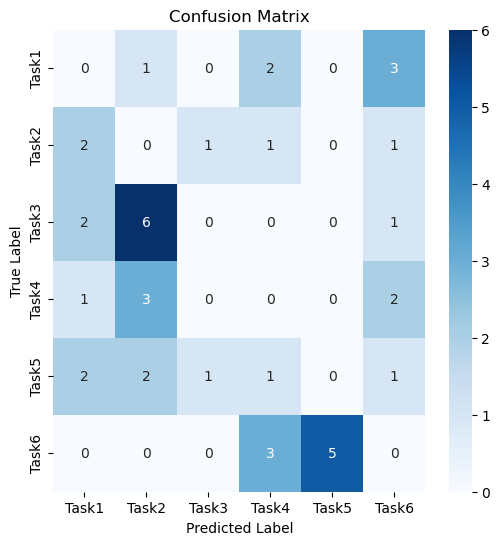

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
# Convert string labels to numbers using LabelEncoder
le = LabelEncoder()
all_labels = sorted(set(true_value + pred))  # Get all unique task names
le.fit(all_labels)  # Fit label encoder to task names

# Transform labels into integers
y_true = le.transform(results_df["True Value"])
y_pred = le.transform(results_df["Prediction"])

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()